# Choosing the profile and dimensions

In [1]:
from pathlib import Path
import os

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize, differential_evolution, basinhopping
from pandas import Series, DataFrame
import pandas as pd

import teslamax
from teslamax import TeslaMaxGeometry, TeslaMaxPreDesign, TeslaMaxModel

import nemplot
from nemplot import nemplot_parameters

from IPython.display import display, HTML

In [2]:
DICT_LINES = 19
K_CRITIC = 0.002
K_STEP = 0.001

B_LABEL = r'$B\ped{h}\,[\si{\tesla}]$'
Q_LABEL = r'$\qc\,[\si{\watt}]$'
COP_LABEL = r'$\cop$'
PHI_LABEL = r'$\Phi$'
H_REG_LABEL = r'$H\,[\si{\milli\meter}]$'
F_B_LABEL = r'$F\ped{B}\,[\si{\percent}]$'
F_M_LABEL = r'$F\ped{M}\,[\si{\percent}]$'
H_MAX_LABEL = r'$\mu_0 H\ped{max}\,[\si{\tesla}]$'



In [3]:
os.chdir(str(Path.home() / "code" / "TeslaMax"))

In [4]:
os.getcwd()

'C:\\Users\\fabiofortkamp\\code\\TeslaMax'

In [5]:
def filter_table_from_column(table,column,value):
    """
    Return a view into the 'table' DataFrame, selecting only the rows where
    'column' equals 'value'
    """
    
    return table[table[column] == value]

In [6]:
FIGSIZE_CM = 12
FONTSIZE = 14

nemplot.set_latex_font("Times New Roman")
nemplot.set_figsize_cm(FIGSIZE_CM)
nemplot.set_fontsize(FONTSIZE)

## 1 Results from AMR simulations

To select the best profile and dimensions, we perform AMR simulations with the following parameters:

In [7]:
# Fixed parameters

FIXED_PARAMETERS_AMR = {
    "D_p[m]": 0.35e-3,
    "L[m]": 85e-3,
    "W[m]": 30e-3,
    "N_r[]": 8,
    "T_H[K]": 305.5,
    "dT[K]": 35,
    "Casing material": "Stainless steel",
    "t_casing[m]": 0.5e-3,
    "t_air[m]": 1e-3,
    "N_layers[]": 3,
    "T_C_layers[K]": np.array([273,283,290]),
    "Length_fraction_layers[%]": np.array([20,20,60]),
    "B_min[T]": 0.05,
    "F_M[%]": 35}

FIXED_PARAMETERS_MAGNET = {"R_i": 0.015,
                "R_o": 0.040,
                "h_fc": 0.005,
                "R_e": 0.3,
                "n_II": 2,
                "n_IV": 4,
                "phi_C_II": 15,
                "mu_r_II": 1.05,
                "mu_r_IV": 1.05,
              "linear_iron": 1,
              "mu_r_iron": 5e3,
             }

### 1.1 AMR maps for $B$ and $H$

To couple with the magnet geometry, we vary the regenerator height, and the air gap height follows. The results are shown in the following figures, for several values of the high magnetic field and regenerator height:

In [8]:
display(HTML("<table><tr><td><img src='figures/Qc_H_regW30.png' width=500></td><td><img src='figures/COP_H_regW30.png' width=500></td></tr></table>"))

,


As a comparison, the figures below use the same parameters, for the system temperature span is kept at $\Delta{}T_\mathrm{sys} = 20\,\mathrm{K}$ and heat exchanger are used at both ends:

In [9]:
display(HTML("<table><tr><td><img src='figures/Qc_H_regW30 - with HEX.png' width=500></td><td><img src='figures/COP_H_regW30 - with HEX.png' width=500></td></tr></table>"))

,


### 1.2 Ability of the magnetic circuit to generate the profile

Now, based on the previous AMR maps, we select an external radius of 100 mm and internal radius of 40 mm, and we vary the air gap height, to see the ability of the TeslaMax model to generate these magnetic profiles.

In [10]:
def get_hgap_map_vectors(R_s,phi_S):
    """
    Return (h_gap, B_max, K) as arrays to be plotted with contourf, 
    based on the magnet optimization maps for 'R_s' and 'phi_S'
    """
    
    filename = "map_K_Rs_%d.txt" %(R_s,)
    
    file_path = Path(filename)
    
    # read the parameters at the header of the file,
    # to extract the number of segments and format the table
    with open(file_path) as f:
        flines = f.readlines()
    
    hgap_map_dict_lines = 14
    
    params = eval("".join(flines[0:hgap_map_dict_lines]))
    
    # parse the results file
    column_names = ["phi_S[deg]",
                    "h_gap[mm]",
                    "B_max[T]",
                   "K[]"]
    
    map_table = pd.read_csv(filename,sep='\t',skiprows=hgap_map_dict_lines,names=column_names,header=0)

    map_table = filter_table_from_column(map_table,"phi_S[deg]",phi_S)
    
    # tip to use pivot from
    # https://stackoverflow.com/questions/24032282/create-contour-plot-from-pandas-groupby-dataframe
    mp = map_table.pivot('B_max[T]','h_gap[mm]','K[]')
     
    X=mp.columns.values
    Y=mp.index.values
    K=mp.values
    h_gap, B_max =np.meshgrid(X, Y)
    
    return (h_gap,B_max,K)

In [11]:
def plot_K_maps(R_s,phi_S):
    
        
    fig, ax = nemplot.create_plot(xlabel=H_REG_LABEL,
                             ylabel=B_LABEL)

    h_gap, B_max, K = get_hgap_map_vectors(R_s,phi_S)
    
    H_reg = h_gap - 2e3*(FIXED_PARAMETERS_AMR["t_air[m]"] + FIXED_PARAMETERS_AMR["t_casing[m]"] )
    
    K_min = np.min(K)
    K_max = np.max(K)
    
    if K_min <= K_CRITIC:
        
        K_values = np.arange(0,K_max+K_STEP,K_STEP)
    else:
        K_values = None
        
    H_contour = ax.contourf(H_reg,B_max,K,
                                levels=K_values,
                                cmap='jet')
        
    H_colorbar = fig.colorbar(H_contour,
                                  ax=ax,
                                 format='%.3f',
                                 ticks=K_values)
    
    H_colorbar.set_label(r'$K\,[\ ]$')

    ax.set_xticks(np.linspace(np.min(H_reg),np.max(H_reg),11))
    
    nemplot.save_figure(fig,"map_K_H_Rs_%d_phi_%d" %(R_s,phi_S))

Plotting for the iron-magnet dividing angles of 35°, 45° and 55°:

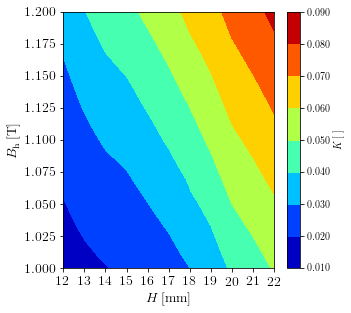

In [12]:
%matplotlib inline
plot_K_maps(100,35)

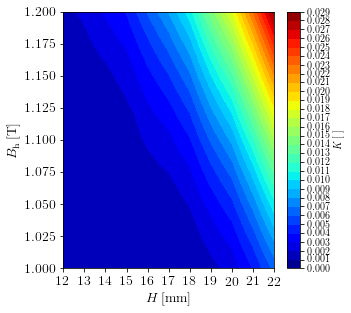

In [13]:
plot_K_maps(100,45)

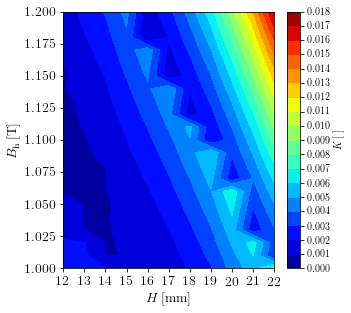

In [14]:
plot_K_maps(100,55)

The critical value of the cost function is $K \le 0.002$. See the **TeslaMax Optimization** notebook for examples.

## 2 The smallest magnet to generate the desired profile

The above maps are helpful to understand the behaviour of the cost function, but they are tied to a particular value of the magnetic circuit.

The AMR simulations do not take the magnet geometry into account. The challenge, from the point of view of magnet design, is fitting the regenerators into an appropriate gap, and then generating the desired profile over the gap.

The perimeter occupied by the regenerators is:

In [15]:
P_regenerator = FIXED_PARAMETERS_AMR["N_r[]"] * FIXED_PARAMETERS_AMR["W[m]"]
print("Regenerator perimeter = %.1f mm" %(P_regenerator*1e3))

Regenerator perimeter = 240.0 mm


From the magnet maps, the average regenerator height is 17 mm, and hence, the average gap height is 20 mm. The gap perimeter is then:

In [16]:
h_gap_mean = 20e-3
R_gap = FIXED_PARAMETERS_MAGNET["R_o"] + h_gap_mean/2
P_gap = 2*np.pi * R_gap
print("Gap perimeter = %.1f mm" %(P_gap*1e3))


Gap perimeter = 314.2 mm


Which means that the gap usage is approximately:

In [17]:
gap_usage = P_regenerator / P_gap
print("Gap usage = %.1f %%" %(gap_usage*1e2,) )

Gap usage = 76.4 %


We can then plot the inverse question from the above maps: for all other parameters fixed, what is the minimum value of the external radius, for given values of the magnetic field and regenerator height, that can be optimized properly (i.e. the cost fucntion is below the critical value)?

Beware that, in the maps below, the maximum radius is 150 mm to avoid too many simulations, so the points at this radius might have a cost function above the critical value:

In [18]:
def get_Rs_map_vectors(R_o,phi_S):
    """
    Return (h_gap, B_max, R_s) as arrays to be plotted with contourf,
    from the results file for 'R_o' (in mm), selecting only the rows
    with dividing angle 'phi_S' [deg]
    """
    
    filename = "map_Rs_Ro_%d.txt" %(R_o,)
    
    file_path = Path(filename)
    
    # read the parameters at the header of the file,
    # to extract the number of segments and format the table
    with open(file_path) as f:
        flines = f.readlines()
        
    params = eval("".join(flines[0:DICT_LINES]))
    
    n = params["n_II"] + params["n_IV"]
    
    # parse the results file
    column_names = ["phi_S[deg]",
                   "h_gap[mm]",
                   "B_max[T]",
                    "R_s[mm]",
                   "K[]"] 
    
    map_table = pd.read_csv(filename,sep='\t',skiprows=DICT_LINES,names=column_names,header=0)
    
    map_table = filter_table_from_column(map_table,'phi_S[deg]',phi_S)
    
    # tip to use pivot from
    # https://stackoverflow.com/questions/24032282/create-contour-plot-from-pandas-groupby-dataframe
    mp = map_table.pivot('B_max[T]','h_gap[mm]','R_s[mm]')
    
    X=mp.columns.values
    Y=mp.index.values
    R_s=mp.values
    h_gap, B_max =np.meshgrid(X, Y)
    
    return (h_gap,B_max,R_s)

Plotting for the iron-magnet angle of 45°:

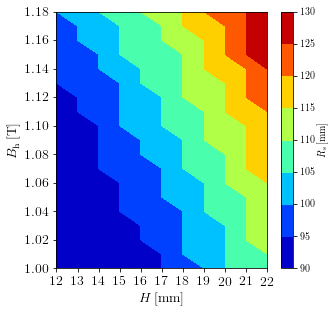

In [19]:
%matplotlib inline

fig, ax = nemplot.create_plot(xlabel=H_REG_LABEL,
                             ylabel=B_LABEL)

h_gap, B_max, R_s = get_Rs_map_vectors(40,45)
H = h_gap - 2e3*(FIXED_PARAMETERS_AMR["t_air[m]"] + FIXED_PARAMETERS_AMR["t_casing[m]"])

R_s_contour = ax.contourf(H,B_max,R_s,cmap='jet')

ax.set_xticks(np.linspace(np.min(H),np.max(H),11))

R_s_colorbar = fig.colorbar(R_s_contour,ax=ax)
R_s_colorbar.set_label(r'$R\ped{s}\,[\si{\mm}]$')

Due to the computational cost of these simulations, the resolution for the axes are low, and hence these maps should only give loose indications of the required size of the magnet for a given profile. The actual shape of the profile should be checked with other simulations.

It is interesting to see that the contours of constant radius are nearly vertical --- which means that, for a constant external radius, it is possible to achieve different profiles when the gap has a constant geometry (just by varying the remanence angles), making it worth to try to use the smallest gap possible.

### 3 Choosing the minimum radius for a given capacity

The above maps can be checked across the AMR maps in Section 1 to then design a compact magnet than can achieve a given capacity.

The procedure belows does this job of comparing these maps. 

First, notice that the target operating point is:

In [20]:
TARGET_OPERATING_POINT = {"Q_c[W]": 36,
                         "dT_sys[K]": 20}

For the heat exchangers that have been tested, a system temperature span of 20 K generate a regenerator temperature span of 35 K, so the maps of section 1 can be used.

To account for numerical errors and for the uncertainty in selecting the heat exchanger, we use a safety factor when specifying the actual target cooling capacity:

In [21]:
SAFETY_FACTOR = 3
Q_C_CRITICAL = TARGET_OPERATING_POINT["Q_c[W]"] * SAFETY_FACTOR

In [30]:
R_S_MIN = 90
R_S_MAX = 120
R_S_STEP = 5

N_QC_LEVELS = 10

B_MIN = 1.00
B_MAX = 1.20

# MAGNET DATA
R_O = 1e3*FIXED_PARAMETERS_MAGNET["R_o"] # [mm]
PHI_S_IV = 45 # [degree]

QC_MAPS_FILE = "AMR_maps_Hreg_W30.txt"

In [31]:
def filter_span_to_20K(table):
    """
    Interpolates the given DataFrame 'table' and return a pandas DataFrame, 
    where all the rows have dT_span = 20 K, """
    
    DT = 20
    
    Teste_vector = table_slope_2D['Teste'].unique()
    table = DataFrame()

    sim_row = {}
    
    i_sim = 1
    for teste in Teste_vector:
        
        table_teste = regsim.filter_table_from_column(table,'Teste',teste)

        f_Qc = interpolate.interp1d(table_teste['Tspan [K]'],table_teste['Qc[W]'], fill_value='extrapolate')
        f_COP = interpolate.interp1d(table_teste['Tspan [K]'],table_teste['COP[-]'], fill_value='extrapolate')

        H = table_teste['H[mm]'].values[0]
        Hmax = table_teste['Hmax[T]'].values[0]

        sim_row["Teste"] = teste
        sim_row["H[mm]"] = H
        sim_row["Hmax[T]"] = Hmax
        sim_row["Qc[W]"] = f_Qc(DT)
        sim_row["COP[-]"] = f_COP(DT)

        sim_row_df = DataFrame(sim_row,index=[i_sim,])
        sim_row_df.index.name = "Case"
        table = pd.concat([table,sim_row_df])
        i_sim = i_sim + 1
                
    return tablev

In [32]:
def get_Rs_map_vectors(R_o,phi_S):
    """
    Return (h_gap, B_max, R_s) as arrays to be plotted with contourf,
    from the results file for 'R_o' (in mm), selecting only the rows
    with dividing angle 'phi_S' [deg]
    """
    
    filename = "map_Rs_Ro_%d.txt" %(R_o,)
    
    file_path = Path(filename)
    
    # read the parameters at the header of the file,
    # to extract the number of segments and format the table
    with file_path.open() as f:
        flines = f.readlines()
        
    params = eval("".join(flines[0:DICT_LINES]))
    
    n = params["n_II"] + params["n_IV"]
    
    # parse the results file
    column_names = ["phi_S[deg]",
                   "h_gap[mm]",
                   "B_max[T]",
                    "R_s[mm]",
                   "K[]"] 
    
    map_table = pd.read_csv(filename,sep='\t',skiprows=DICT_LINES,names=column_names,header=0)
    
    map_table = filter_table_from_column(map_table,'phi_S[deg]',phi_S)
    
    # tip to use pivot from
    # https://stackoverflow.com/questions/24032282/create-contour-plot-from-pandas-groupby-dataframe
    mp = map_table.pivot('B_max[T]','h_gap[mm]','R_s[mm]')
    
    X=mp.columns.values
    Y=mp.index.values
    R_s=mp.values
    h_gap, B_max =np.meshgrid(X, Y)
    
    return (h_gap,B_max,R_s)

In [33]:
(h_gap,B_max,R_s) = get_Rs_map_vectors(40,45)

In [34]:
R_s

array([[  90.,   90.,   90.,   95.,   95.,   95.,  100.,  100.,  105.,
         110.,  110.],
       [  90.,   90.,   90.,   95.,   95.,   95.,  100.,  105.,  105.,
         110.,  110.],
       [  90.,   90.,   90.,   95.,   95.,  100.,  100.,  105.,  105.,
         110.,  115.],
       [  90.,   90.,   90.,   95.,   95.,  100.,  100.,  105.,  105.,
         110.,  115.],
       [  90.,   90.,   90.,   95.,  100.,  100.,  100.,  105.,  110.,
         110.,  115.],
       [  90.,   90.,   95.,   95.,  100.,  100.,  105.,  105.,  110.,
         110.,  115.],
       [  90.,   90.,   95.,   95.,  100.,  100.,  105.,  105.,  110.,
         115.,  115.],
       [  90.,   95.,   95.,  100.,  100.,  100.,  105.,  110.,  110.,
         115.,  120.],
       [  90.,   95.,   95.,  100.,  100.,  105.,  105.,  110.,  110.,
         115.,  120.],
       [  90.,   95.,   95.,  100.,  100.,  105.,  105.,  110.,  115.,
         115.,  120.],
       [  95.,   95.,   95.,  100.,  105.,  105.,  110.,  11

In [35]:
def plot_Qc_and_Rs_contour():    
    
    table_Qc = pd.read_csv(QC_MAPS_FILE,sep='\t')

    HMax_vector = table_Qc['Hmax[T]'].unique()
    H_reg_vector = table_Qc['H[mm]'].unique()

    Qc_matrix = np.zeros((len(HMax_vector),len(H_reg_vector)))
    COP_matrix = Qc_matrix.copy()
    
    fig_list = []
    table_list = []
    
    fig_Qc, ax_Qc = nemplot.create_plot(title='',
                                        xlabel=H_REG_LABEL,
                                        ylabel=H_MAX_LABEL) 

    Qc_vector = table_Qc['Qc[W]'].values
    COP_vector = table_Qc['COP[-]'].values
    
    #transformando o vetor Qc em matriz
    cont = 0
    for i in range(len(H_reg_vector)):
        for j in range(len(HMax_vector)):                            
            Qc_matrix[j,i] = Qc_vector[cont]
            COP_matrix[j,i] = COP_vector[cont]
            cont += 1
    
    H_reg_grid,B_max_grid = np.meshgrid(H_reg_vector,HMax_vector)
    
    Q_c_min = np.min(Qc_matrix)
    Q_c_max = np.max(Qc_matrix)
    
    # build the Q_c_levels by partinioning the range below and above the critical value,
    # making sure it is included in the list
    Q_c_levels = np.append(np.linspace(Q_c_min,Q_C_CRITICAL,int(N_QC_LEVELS/2),endpoint=False),
                           np.linspace(Q_C_CRITICAL,Q_c_max,int(N_QC_LEVELS/2)))
    
    p_Qc = ax_Qc.contour(H_reg_grid,B_max_grid,Qc_matrix,Q_c_levels,colors='b')
    ax_Qc.clabel(p_Qc,fmt="%d",fontsize=0.9*nemplot_parameters["FONTSIZE"])
    
    # fill the contour between the critical and the maximum value of cooling capacity
    p_Qc_fill = ax_Qc.contourf(H_reg_grid,
                               B_max_grid,
                               Qc_matrix,
                               levels=[Q_C_CRITICAL,Q_c_max,],
                              cmap='Blues')
    
    # load the magnet data
    h_gap_magnet,B_max_magnet,R_s_magnet = get_Rs_map_vectors(R_O,PHI_S_IV)
    H_reg_magnet = h_gap_magnet - 2e3*(FIXED_PARAMETERS_AMR["t_casing[m]"] + FIXED_PARAMETERS_AMR["t_air[m]"])
    p_Rs = ax_Qc.contour(H_reg_magnet,
                         B_max_magnet,
                         R_s_magnet,
                         levels=np.arange(R_S_MIN,R_S_MAX + R_S_STEP,R_S_STEP),
                         colors='r')
    ax_Qc.clabel(p_Rs,
                 fmt="%d",
                 fontsize=0.9*nemplot_parameters["FONTSIZE"],
                rightside_up=False)
    
    
    H_reg_min = np.min(H_reg_magnet)
    H_reg_max = np.max(H_reg_magnet)
    dH_reg = 2
    
    H_reg_ticks = np.arange(H_reg_min, H_reg_max + dH_reg, dH_reg)
    
    ax_Qc.set_xlim(np.min(H_reg_magnet),np.max(H_reg_magnet))
    ax_Qc.set_xticks(H_reg_ticks)
    nemplot.refine_xticks(ax_Qc,5)
    
    B_max_min = B_MIN
    B_max_max = B_MAX
    dB_max = 0.05
    
    ax_Qc.set_ylim(B_MIN,B_MAX)
    B_max_ticks = np.arange(B_max_min,B_max_max + dB_max, dB_max)
    ax_Qc.set_yticks(B_max_ticks)
    nemplot.refine_yticks(ax_Qc,5)
    
    fig_list.append(fig_Qc)

    
    nemplot.save_figure(fig_Qc,
                        name='contour_Qc_Rs_W30')

    return fig_list, table_list

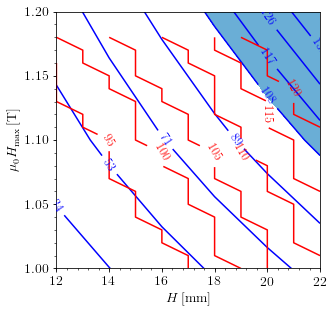

In [36]:
fig_list_slope2D_35K = plot_Qc_and_Rs_contour()